In [2]:
import re
import srt 
import glob
import pandas as pd
import os
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import spacy

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    HalvingRandomSearchCV
)
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score, roc_auc_score,
    classification_report, make_scorer
)

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import NearMiss 

from catboost import CatBoostClassifier, CatBoostRegressor, Pool

c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [3]:
files = glob.glob("./English_level/data_all/Subtitles_all/*.srt")

In [4]:
HTML = r'<.*?>'
TAG = r'{.*?}'
COMMENTS = r'[\(\[][A-Z ]+[\)\]]'
LETTERS = r'[^a-zA-Z\'.,!? ]'
SPACES = r'([ ])\1+'
DOTS = r'[\.]+'

def clean_subs(subs):
    txt = re.sub(HTML, ' ', subs) #html тэги меняем на пробел
    txt = re.sub(TAG, ' ', txt) #тэги меняем на пробел
    txt = re.sub(COMMENTS, ' ', txt) #комменты меняем на пробел
    txt = re.sub(LETTERS, ' ', txt) #все что не буквы меняем на пробел
    txt = re.sub(SPACES, r'\1', txt) #повторяющиеся пробелы меняем на один пробел
    txt = re.sub(DOTS, r'.', txt)  #многоточие меняем на точку
    # txt = txt.encode('ascii', 'ignore').decode() #удаляем все что не ascii символы   
    # txt = ".".join(txt.lower().split('.')[1:-1]) #удаляем первый и последний субтитр (обычно это реклама)
    return txt

In [5]:
dframes = {}

for filename in files:
    try:
        with open(filename) as f:
            subtitle_generator = srt.parse(f.read().encode('ascii', 'ignore').decode())
            df = pd.DataFrame(list([[item.start, item.end, item.content] for item in subtitle_generator]), columns=['start','end','content'])
            df['content'] = df['content'].apply(clean_subs)
            df['content'] = df['content'].str.strip().replace('', np.nan).str.lower()
            df.dropna(subset=['content'], inplace=True)
            df.reset_index(drop=True, inplace=True)

            dframes[os.path.basename(f.name)] = df

    except srt.SRTParseError as e:
        print(filename, e)

In [6]:
YEAR_SRT = r'(\(\d{4}\))'
CLEAN_TEXT = r'[^a-z\s\|]'

In [7]:
names_df = pd.DataFrame([n for n in dframes], columns=['name'])
names_df['year'] = names_df['name'].str.extract(YEAR_SRT, flags=0)
names_df['parsed_name'] = names_df.apply(lambda x: x['name'].replace(str(x['year']), '').replace('_', ' ').replace('.srt', ''), axis=1)

In [8]:
labels = pd.read_csv('English_level/data_all/labels_all.csv')
display(labels)

,Movie,Kinopoisk,Level,Subtitles
0,Forrest Gump,Rus sub,"A2/A2+, B1",Yes
1,Finding Nemo\n,Everything,A2/A2+,Yes
2,Cast away\n,"Paid, Rus sub",A2/A2+,Yes
3,The invisible man (2020)\n,"Paid, Rus lan",A2/A2+,Yes
4,Back to the future\n,Rus sub,A2/A2+,Yes
...,...,...,...,...
106,Klaus,NaN,C1,NaN
107,Ocean’s Eleven,NaN,C1,NaN
108,Ocean’s Twelve,NaN,C1,NaN
109,Bridget Jones’s Baby,NaN,C1,NaN


In [9]:
for index in labels.index:
    item = labels.loc[index, 'Movie']
    found = process.extractOne(item, names_df['parsed_name'])
    labels.loc[index, ['found', 'probability', 'index']] = found

labels['index'] = labels['index'].astype(int)
    

In [10]:
films = labels.set_index('index').join(names_df)
display(films)

,Movie,Kinopoisk,Level,Subtitles,found,probability,name,year,parsed_name
index,,,,,,,,,
37,Forrest Gump,Rus sub,"A2/A2+, B1",Yes,Forrest Gump,100.0,Forrest_Gump(1994).srt,(1994),Forrest Gump
36,Finding Nemo\n,Everything,A2/A2+,Yes,Finding Nemo,100.0,Finding_Nemo(2003).srt,(2003),Finding Nemo
21,Cast away\n,"Paid, Rus sub",A2/A2+,Yes,Cast away,100.0,Cast_away(2000).srt,(2000),Cast away
91,The invisible man (2020)\n,"Paid, Rus lan",A2/A2+,Yes,The invisible man,95.0,The_invisible_man(2020).srt,(2020),The invisible man
8,Back to the future\n,Rus sub,A2/A2+,Yes,Back to the future,100.0,Back_to_the_future(1985).srt,(1985),Back to the future
...,...,...,...,...,...,...,...,...,...
48,Klaus,NaN,C1,NaN,Klaus,100.0,Klaus(2019).srt,(2019),Klaus
67,Ocean’s Eleven,NaN,C1,NaN,Oceans Eleven,96.0,Oceans_Eleven(2001).srt,(2001),Oceans Eleven
68,Ocean’s Twelve,NaN,C1,NaN,Oceans Twelve,96.0,Oceans_Twelve(2004).srt,(2004),Oceans Twelve


In [11]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatize(text):    
    doc = nlp(text)
    
    lemmatized_text = ' '.join(['' if token.is_stop else token.lemma_ for token in doc])
    lemmatized_text = re.sub(CLEAN_TEXT, ' ', lemmatized_text)
    lemmatized_text = re.sub(SPACES, r'\1', lemmatized_text)

    return lemmatized_text.split('|')

In [12]:
films['Level'].unique()

array(['A2/A2+, B1', 'A2/A2+', 'A2/A2+/B1', 'B1', 'B1, B2', 'B2', 'B1/B2',
       'C1'], dtype=object)

In [13]:
def search_best_estimator(pipeline, param_grid, x, y):
    hrs = HalvingRandomSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring='f1_weighted',
        cv=3,
        n_candidates="exhaust",
        factor=5,
        n_jobs=-1,
    )
    _ = hrs.fit(x, y)
    return hrs.best_estimator_

In [14]:
def plot_confusion_matrix(y_test, y_preds, model):
    fig, ax = plt.subplots(figsize=(8,5))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
    cmp.plot(ax=ax)
    plt.show()

In [15]:
for index in films.index:
    name = films.loc[index, 'name']
    text = '|'.join(dframes[name]['content'])
    result = lemmatize(text)
    dframes[name]['content'] = pd.Series(result)
#     dframes[name].to_csv('Parsed/srt/' + name + '.csv')

In [16]:
films

,Movie,Kinopoisk,Level,Subtitles,found,probability,name,year,parsed_name
index,,,,,,,,,
37,Forrest Gump,Rus sub,"A2/A2+, B1",Yes,Forrest Gump,100.0,Forrest_Gump(1994).srt,(1994),Forrest Gump
36,Finding Nemo\n,Everything,A2/A2+,Yes,Finding Nemo,100.0,Finding_Nemo(2003).srt,(2003),Finding Nemo
21,Cast away\n,"Paid, Rus sub",A2/A2+,Yes,Cast away,100.0,Cast_away(2000).srt,(2000),Cast away
91,The invisible man (2020)\n,"Paid, Rus lan",A2/A2+,Yes,The invisible man,95.0,The_invisible_man(2020).srt,(2020),The invisible man
8,Back to the future\n,Rus sub,A2/A2+,Yes,Back to the future,100.0,Back_to_the_future(1985).srt,(1985),Back to the future
...,...,...,...,...,...,...,...,...,...
48,Klaus,NaN,C1,NaN,Klaus,100.0,Klaus(2019).srt,(2019),Klaus
67,Ocean’s Eleven,NaN,C1,NaN,Oceans Eleven,96.0,Oceans_Eleven(2001).srt,(2001),Oceans Eleven
68,Ocean’s Twelve,NaN,C1,NaN,Oceans Twelve,96.0,Oceans_Twelve(2004).srt,(2004),Oceans Twelve


In [17]:
content = []
titles = []

for name in dframes:
    titles.append(name)
    content.append(''.join(dframes[name]['content']))

In [18]:
films = films.set_index('name').join(pd.DataFrame(data={'name':titles, 'content':content}).set_index('name'))

In [19]:
def getClass(title):
    if title.find('C1') >= 0:
        return 'C1'
    if title.find('B2') >= 0:
        return 'B2'
    if title.find('B1') >= 0:
        return 'B1'
    if title.find('A2+') >= 0:
        return 'A2/A2+'

In [20]:
films['One_Level'] = films['Level'].apply(getClass)

In [21]:
df_films = films[['One_Level', 'content']].reset_index(drop=True)
df_films.columns = ['level', 'content']

In [22]:
def split_text(df, factor = 2):
    df_splitted = df
    for i in range(factor):
        new_data = []
        for i in df_splitted.index:
            content = df_splitted.loc[i, 'content'].split(' ')
            middle = len(content) // 2
            new_data.append({'level': df_splitted.loc[i, 'level'], 'content': ' '.join(content[0:middle]) })
            new_data.append({'level': df_splitted.loc[i, 'level'], 'content': ' '.join(content[middle: len(content)]) })

        df_splitted = pd.DataFrame(new_data)

    return df_splitted

In [23]:
df_films_splitted = split_text(df_films, factor=4)

In [24]:
df_films_splitted['level'].value_counts()

B1        640
B2        608
A2/A2+    400
C1        128
Name: level, dtype: int64

c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=74. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


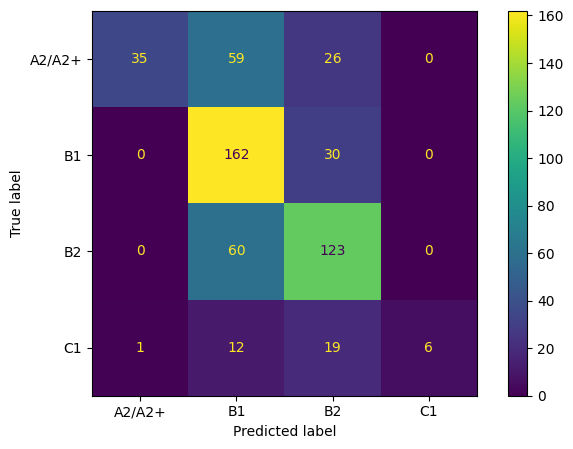

In [25]:
x, y = df_films_splitted['content'].tolist(), df_films_splitted['level'].tolist()

pipeline = Pipeline(
    steps = [("tfidf", TfidfVectorizer() ),("base", RandomForestClassifier() )]
)

param_grid = {
    # "tfidf__min_df": [i for i in range(25,35,5)],
    # "base__n_estimators": [i for i in range(150,250,50)],
    # "base__max_depth": [i for i in range(25,35,5)],
    # "base__min_samples_split":[i for i in range(6,10,2)],
    # "base__min_samples_leaf": [2],
}

estimator = search_best_estimator(pipeline, param_grid, x, y)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.3, stratify=y
)
estimator.fit(X_train, y_train)
y_preds = estimator.predict(X_test)
plot_confusion_matrix(y_test, y_preds, estimator)

c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=21. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


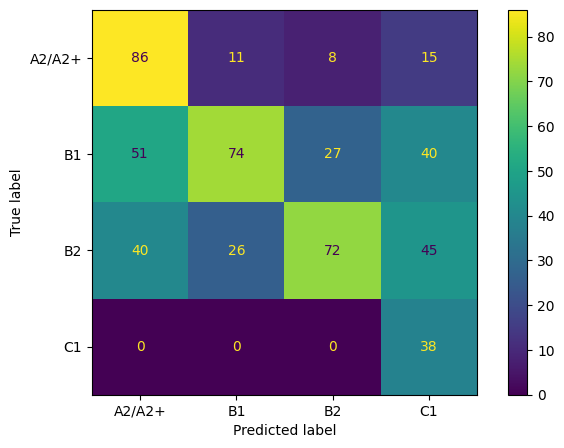

In [28]:
vectorizer = TfidfVectorizer(min_df=30)
vectorizer.fit(x)

# for i in vectorizer.vocabulary_:
#     vectorizer.vocabulary_[i] = vectorizer.vocabulary_[i] * 0.2

vect_x = vectorizer.transform(x)

nm = NearMiss()
X_res, Y_res = nm.fit_resample(vect_x, y)
pipeline2 = Pipeline( steps = [("base", RandomForestClassifier() )]  )
# CatBoostClassifier(task_type='GPU')
param_grid2 = {
    # "base__n_estimators": [i for i in range(200,300,50)],
    # "base__max_depth": [i for i in range(25,35,5)],
    # "base__min_samples_split": [i for i in range(8,12,2)],
}
estimator2 = search_best_estimator(pipeline2, param_grid2, X_res, Y_res)
X_train, X_test, y_train, y_test = train_test_split(
    vect_x, y, random_state=42, test_size=0.3, stratify=y
)
estimator2.fit(X_res, Y_res)
y_preds2 = estimator2.predict(X_test)
plot_confusion_matrix(y_test, y_preds2, estimator2)

In [31]:
# https://stackoverflow.com/a/69678207

<1776x1572 sparse matrix of type '<class 'numpy.float64'>'
	with 200489 stored elements in Compressed Sparse Row format>